# Глубокие Нейронные сетти

## Библиотеки

In [73]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import requests
import torch

from torchvision import datasets, transforms


In [3]:
import warnings
warnings.filterwarnings("ignore")

## Зададим устройство исполнения кода (cpu/cuda)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Полезный код для обучения модели

In [53]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    """
    x_batch has a shape [batch_size, input_dim]
    y_batch has a shape [batch_size]
    """
    model.train()
    model.zero_grad()
    
    output = model(x_batch.to(device))
    
    loss = loss_function(output, y_batch.to(device))
    loss.backward()

    optimizer.step()
    return loss.cpu().cpu().item()

In [54]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device), batch_of_y.to(device), optimizer, loss_function)
        
        if callback is not None:
            callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total
        

In [55]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

## Сверточная нейронная сеть

In [56]:
class CNN(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device
        
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layers = torch.nn.Sequential()
        self.layers.add_module('conv1', torch.nn.Conv2d(1, 1*6, kernel_size = 5))
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('pool1', torch.nn.MaxPool2d(kernel_size = 2))
        self.layers.add_module('conv2', torch.nn.Conv2d(1*6, 1*16, kernel_size = 5))
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('pool2', torch.nn.MaxPool2d(kernel_size = 2))
        self.layers.add_module('flatten', torch.nn.Flatten())
        self.layers.add_module('linear1', torch.nn.Linear(16*4*4, 120))
        self.layers.add_module('relu3', torch.nn.ReLU())
        self.layers.add_module('linear2', torch.nn.Linear(120, 84))
        self.layers.add_module('relu4', torch.nn.ReLU())
        self.layers.add_module('linear3', torch.nn.Linear(84, 10))

    def forward(self, input):
        return self.layers(input)

## Выборка

In [57]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

In [58]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

model = CNN()
model.to(device)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=256, out_features=120, bias=True)
    (relu3): ReLU()
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu4): ReLU()
    (linear3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [59]:
batch_generator = torch.utils.data.DataLoader(dataset = MNIST_test, 
                                              batch_size=64)
            
pred = []
real = []
test_loss = 0
for it, (x_batch, y_batch) in enumerate(batch_generator):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    output = model(x_batch)

    test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch)

    pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
    real.extend(y_batch.cpu().numpy().tolist())

test_loss /= len(MNIST_test)

print('loss: {}'.format(test_loss))

loss: 2.3041260536193846


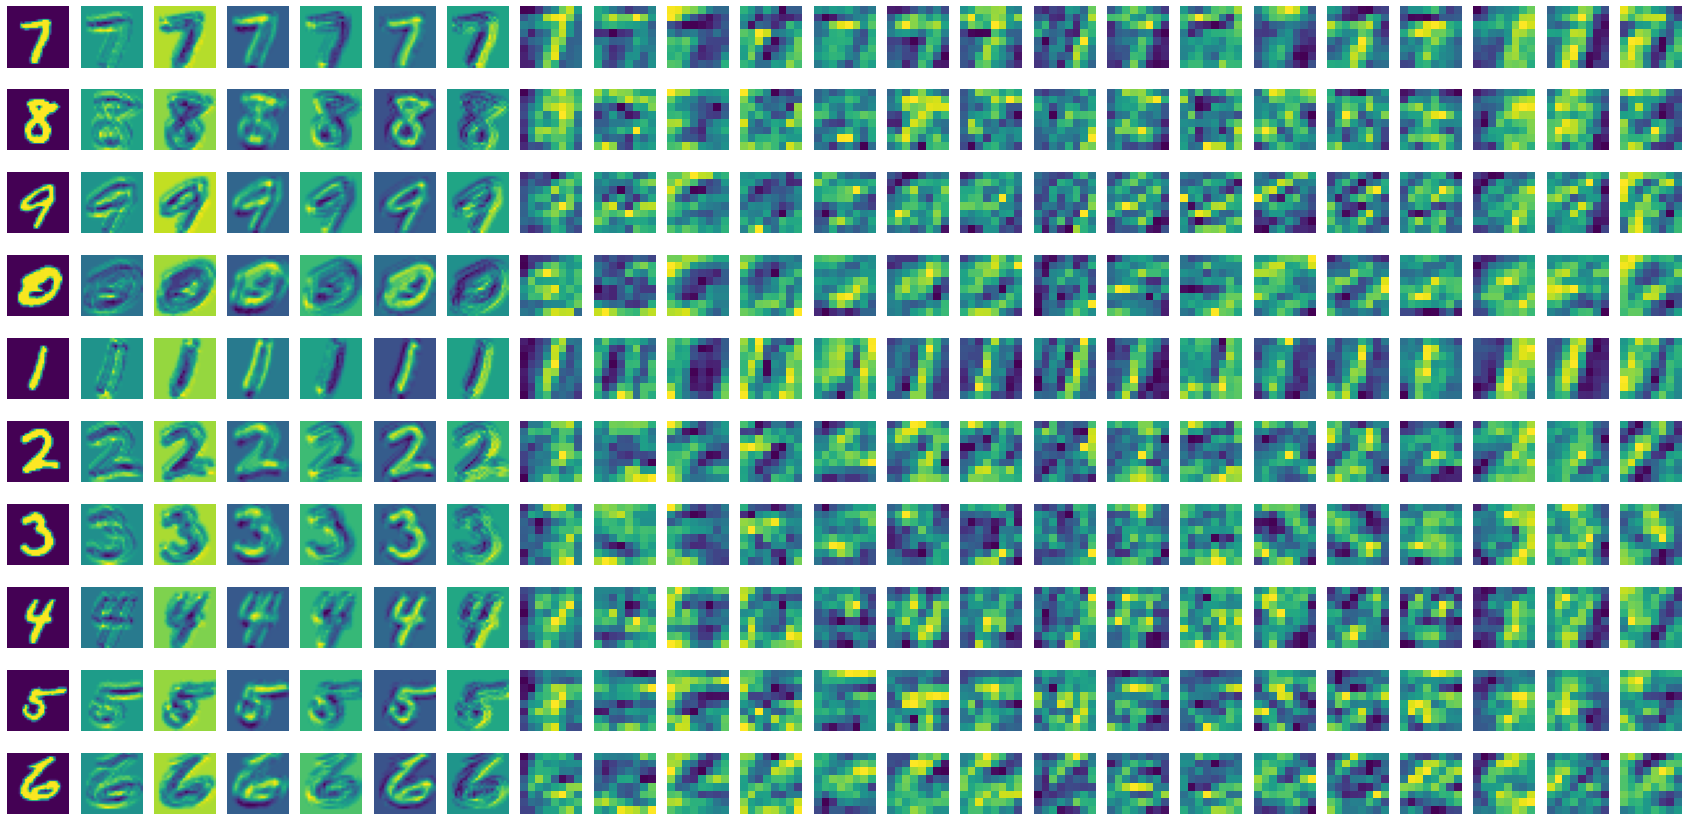

In [60]:
x = x_batch[-10:]
y = model.layers.conv1(x)
z = model.layers.conv2(model.layers.pool1(model.layers.relu1(y)))

fig = plt.figure(figsize=(30, 15))
gs = gridspec.GridSpec(10, 23)
ax = np.empty([10, 23], dtype=object)
for i in range(10):
    for j in range(23):
        ax[i][j] = fig.add_subplot(gs[i, j])
for i in range(len(x)):
    ax[i][0].imshow(x.cpu().data[i, 0].numpy())
    ax[i][0].axis("off")
    for j in range(1, 7):
        ax[i][j].imshow(y.cpu().data[i, j-1].numpy())
        ax[i][j].axis("off")

    for j in range(7, 23):
        ax[i][j].imshow(z.cpu().data[i, j-7].numpy())
        ax[i][j].axis("off")

In [61]:
trainer(count_of_epoch = 1,
        batch_size = 64,
        dataset = MNIST_train,
        model = model,
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = None)

In [62]:
batch_generator = torch.utils.data.DataLoader(dataset = MNIST_test, 
                                              batch_size=64)
            
pred = []
real = []
test_loss = 0
for it, (x_batch, y_batch) in enumerate(batch_generator):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    output = model(x_batch)

    test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch)

    pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
    real.extend(y_batch.cpu().numpy().tolist())

test_loss /= len(MNIST_test)

print('loss: {}'.format(test_loss))

loss: 0.08720074153020978


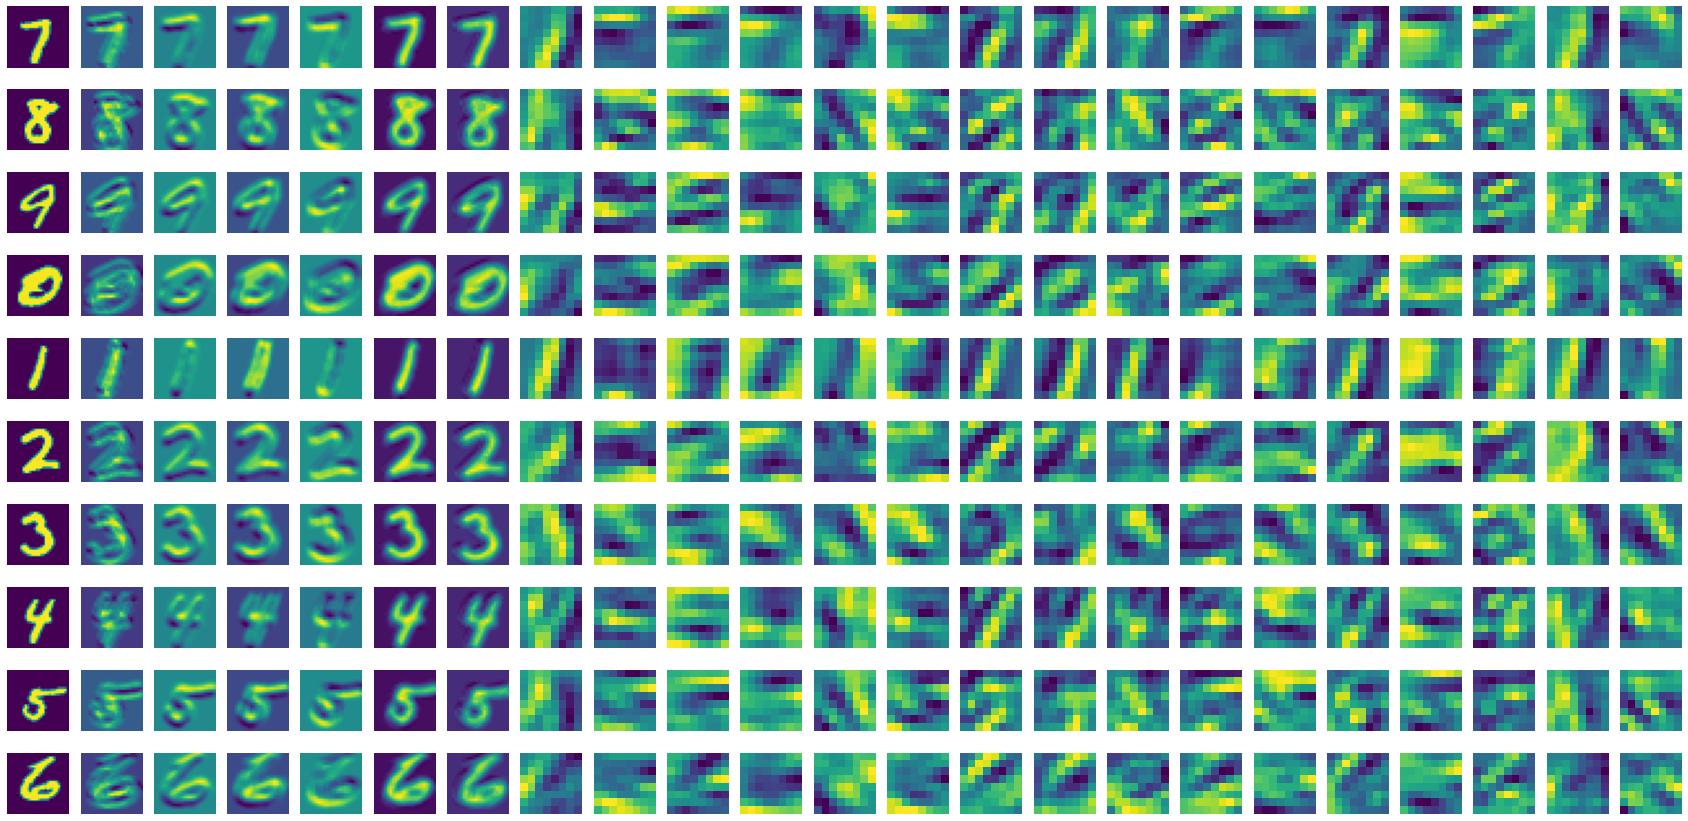

In [63]:
x = x_batch[-10:]
y = model.layers.conv1(x)
z = model.layers.conv2(model.layers.pool1(model.layers.relu1(y)))

fig = plt.figure(figsize=(30, 15))
gs = gridspec.GridSpec(10, 23)
ax = np.empty([10, 23], dtype=object)
for i in range(10):
    for j in range(23):
        ax[i][j] = fig.add_subplot(gs[i, j])
for i in range(len(x)):
    ax[i][0].imshow(x.cpu().data[i, 0].numpy())
    ax[i][0].axis("off")
    for j in range(1, 7):
        ax[i][j].imshow(y.cpu().data[i, j-1].numpy())
        ax[i][j].axis("off")

    for j in range(7, 23):
        ax[i][j].imshow(z.cpu().data[i, j-7].numpy())
        ax[i][j].axis("off")

## Рекурентная нейронная сеть (seq2seq архитектура) 

In [65]:
class Encoder(torch.nn.Module):
    r'''
    Модель энкодера предложения.
    '''
    @property
    def device(self):
        for p in self.parameters():
            return p.device
        
    def __init__(self,
                 vocab_dim,
                 emb_dim = 10, 
                 hidden_dim = 10,
                 num_layers = 3,
                 bidirectional = False):
        super(Encoder, self).__init__()
        
        self.num_direction = int(bidirectional + 1)
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim

        self.embedding = torch.nn.Embedding(vocab_dim, emb_dim)

        self.encoder = torch.nn.LSTM(
            emb_dim, hidden_dim, num_layers, bidirectional = bidirectional)
        
    def forward(self, input):
        r'''
        Возвращает скрытые состояния всех токенов d, 
            а также скрытые состояния со всех слоев для последнего токена (h, c).
        :param input:
            тензор размера batch_size \times seq_len \times emb_dim
        :type input: tensor
        '''
        input = self.embedding(input)
        input = torch.transpose(input, 0, 1)
        d, (h, c) = self.encoder(input)
        return d, torch.transpose(h, 0, 1) , torch.transpose(c, 0, 1)


In [66]:
class Decoder(torch.nn.Module):
    r'''
    Модель декодера (генератора) предложения.
    '''
    @property
    def device(self):
        for p in self.parameters():
            return p.device
    def __init__(self,
                 vocab_dim,
                 output_dim,
                 emb_dim = 10, 
                 hidden_dim = 10,
                 num_layers = 3,
                 bidirectional = False):
        super(Decoder, self).__init__()
        
        self.num_direction = int(bidirectional + 1)
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.embedding = torch.nn.Embedding(vocab_dim, self.emb_dim)

        self.decoder = torch.nn.LSTM(
            emb_dim, hidden_dim, num_layers, bidirectional = bidirectional)

        self.linear = torch.nn.Linear(
            self.num_direction*hidden_dim, output_dim)

    def forward(self, real=None, h = None, c = None, max_len = 50):
        r'''
        :param real: нужен только для обучения
            тензор размера batch_size \times seq_len \times emb_dim
        :type real: tensor
        :param h: скрытое состояния, если не задано, то генерится случайное
            тензор размера batch_size \times num_layer \times hidden_dim*num_direction
        :type h: tensor
        :param c: скрытое состояния, если не задано, то генерится случайное
            тензор размера batch_size \times num_layer \times hidden_dim*num_direction
        :type c: tensor
        :param max_len: сколько символов сгенерить
        :type max_len: int
        '''
        batch_size = 1
        if h is not None:
            batch_size = h.shape[0]
        if c is not None:
            batch_size = c.shape[0]
        if real is not None:
            batch_size = real.shape[0]


        if real is not None:
            input = self.embedding(real)

            if h is None:
                h = torch.randn(
                    (batch_size, self.num_layers, self.num_direction*self.hidden_dim)).to(
                        self.device
                    )
            if c is None:
                c = torch.randn(
                    (batch_size, self.num_layers, self.num_direction*self.hidden_dim)).to(
                        self.device
                    )

            input = torch.transpose(input, 0, 1)
            h = torch.transpose(h, 0, 1)
            c = torch.transpose(c, 0, 1)
            d, _ = self.decoder(input, (h, c))
            answers = self.linear(d)
        else:
            input = self.embedding(
                torch.tensor(
                    [[char2idx['<START>']] for _ in range(
                        batch_size)]).long().to(
                        self.device
                    )
                )

            if h is None:
                h = torch.randn(
                    (batch_size, self.num_layers, self.num_direction*self.hidden_dim)).to(
                        self.device
                    )
            if c is None:
                c = torch.randn(
                    (batch_size, self.num_layers, self.num_direction*self.hidden_dim)).to(
                        self.device
                    )

            input = torch.transpose(input, 0, 1)
            h = torch.transpose(h, 0, 1)
            c = torch.transpose(c, 0, 1)

            answers = torch.zeros(
                (max_len, input.shape[1], self.output_dim)).to(
                    self.device)
                
            for i in range(max_len):
                d, (h, c) = self.decoder(input, (h, c))
                answers[i, :, :] = self.linear(d)[0]
                input = self.embedding(
                    torch.argmax(answers[i:i+1, :, :], dim=-1))

        return torch.transpose(answers, 0, 1)

In [68]:
def batch_generator(dataset, char2idx, batch_size=64, shuffle=True):
    X, Y = dataset[:-1], dataset[1:]
    
    PAD = char2idx['<PAD>']
    n_samples = len(X)

# генерим список индексов
    list_of_indexes = np.linspace(
        0, n_samples - 1, n_samples, dtype=np.int64)
    List_X = []
    List_Y = []
    
# если нужно перемешать, то перемешиваем
    if shuffle:
        np.random.shuffle(list_of_indexes)
        

# сгенерировал список индексов, по этим индексам, 
# сделаем новый перемешаный спиисок токенов и тэгов
    for indx in list_of_indexes:
        List_X.append(X[indx])
        List_Y.append(Y[indx])
    
    n_batches = n_samples//batch_size
    if n_samples%batch_size != 0:
        n_batches+=1
        
    # For each k yield pair x and y
    for k in range(n_batches):
# указываем текущии размер батча
        this_batch_size = batch_size
    
# если мы выдаем последний батч, то его нужно обрезать
        if k == n_batches - 1:
            if n_samples%batch_size > 0:
                this_batch_size = n_samples%batch_size
                
        This_X = List_X[k*batch_size:k*batch_size + this_batch_size]
        This_Y = List_Y[k*batch_size:k*batch_size + this_batch_size]
        
        This_X_line = [
                       [char2idx.get(char, 0) for char in sent]\
                       for sent in This_X]
        This_Y_line = [
                       [char2idx.get('<START>', 0)]\
                       + [char2idx.get(char, 0) for char in sent]\
                       + [char2idx.get('<FINISH>', 0)]\
                       for sent in This_Y]

        List_of_length_x = [len(sent) for sent in This_X_line]
        length_of_sentence_x = max(List_of_length_x)
        List_of_length_y = [len(sent) for sent in This_Y_line]
        length_of_sentence_y = max(List_of_length_y)

        x_arr = np.ones(shape=[this_batch_size, length_of_sentence_x])*PAD
        y_arr = np.ones(shape=[this_batch_size, length_of_sentence_y])*PAD

        for i in range(this_batch_size):
            x_arr[i, :len(This_X_line[i])] = This_X_line[i]
            y_arr[i, :len(This_Y_line[i])] = This_Y_line[i]

        x = torch.LongTensor(x_arr)
        y = torch.LongTensor(y_arr)
        lengths = torch.LongTensor(List_of_length_x)

        yield x, y

In [69]:
def train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function):
    encoder, decoder = model
    encoder.train()
    decoder.train()
    encoder.zero_grad()
    decoder.zero_grad()
    
    d, h, c = encoder(batch_of_x.to(encoder.device))
    output = decoder(
        batch_of_y.to(decoder.device), 
        h=h.to(decoder.device)[:, -decoder.num_layers:, :], 
        c=c.to(decoder.device)[:, -decoder.num_layers:, :])

    loss = loss_function(output.to(decoder.device)[:, :-1, :].transpose(1, 2), batch_of_y[:, 1:])
    
    loss.backward()
    optimizer.step()
    
    return loss.cpu().item()

In [83]:
def train_epoch(train_generator, model, loss_function, optimizer):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        local_loss = train_on_batch(
            model, batch_of_x, batch_of_y, optimizer, loss_function)
        train_generator.set_postfix({'train batch loss': local_loss})

        epoch_loss += local_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [89]:
def trainer(count_of_epoch, 
            batch_size,
            model,
            dataset,
            char2idx,
            loss_function,
            optimizer,):
    iterations = tqdm(range(count_of_epoch))

    for it in iterations:
        optima = optimizer

        number_of_batch = len(dataset)//batch_size + (len(dataset)%batch_size>0)
        generator = tqdm(
            batch_generator(dataset, char2idx, batch_size, device=device), 
            leave=False, total=number_of_batch)
        
        epoch_loss = train_epoch(
            train_generator = generator, model = model, 
            loss_function = loss_function, 
            optimizer = optima)
        
        encoder, decoder = model
        encoder.eval()
        decoder.eval()
        
        sent = dataset[5].lower()
        x = torch.LongTensor([[char2idx[char] for char in sent]]).to(device)
        d, h, c = encoder(x)

        result =''.join(
          [idx2char[index] for index in torch.argmax(
              decoder(
                  h=torch.zeros_like(h[:, -decoder.num_layers:, :]).float(), 
                  c=torch.zeros_like(h[:, -decoder.num_layers:, :]).float(), 
                  max_len=30), dim=-1).detach().cpu().numpy()[0]])

        iterations.set_postfix({'train epoch loss': epoch_loss, 
                                'example': result})

In [75]:
text = requests.get(
    'https://raw.githubusercontent.com/andriygav/MachineLearning/master/seq2seq/data/602016.txt').text

In [76]:
char2idx = {'<PAD>':0, '<UNK>': 1, '<START>': 2, '<FINISH>': 3}
idx2char = {0: '<PAD>', 1: '<UNK>', 2: '<START>', 3: '<FINISH>'}
for item in list(set(text)):
    char2idx[item] = len(char2idx)
    idx2char[char2idx[item]] = item

In [77]:
dataset = [sent.strip() for sent in text.split('\n') if len(sent.strip()) > 20 and len(sent.strip()) < 300 ]

len(dataset)

34076

In [85]:
encoder = Encoder(vocab_dim=len(char2idx), 
                  num_layers=2, emb_dim=100, hidden_dim=100)
encoder.to(device)
decoder = Decoder(vocab_dim=len(char2idx), 
                  output_dim=len(char2idx), num_layers=2, emb_dim=100, hidden_dim=100)
decoder.to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss(ignore_index=char2idx['<PAD>'])

In [ ]:
trainer(count_of_epoch = 100,
        batch_size = 64,
        model = (encoder, decoder),
        dataset = dataset, 
        char2idx = char2idx,
        loss_function = loss_function,
        optimizer = optimizer)